Files already downloaded and verified
Files already downloaded and verified
cuda
tensor([1, 6, 4, 0, 2, 6, 1, 2, 7, 6, 0, 4, 7, 4, 9, 0, 6, 4, 5, 7, 1, 4, 3, 0,
        6, 5, 3, 8, 6, 6, 4, 2, 4, 3, 2, 8, 7, 2, 9, 1], device='cuda:0')


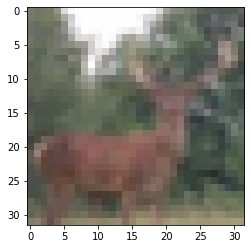

In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import numpy as np
import sys
sys.path.append('/home/hrushikesh/')
from torch_functions import *
import foolbox as fb
import matplotlib.pyplot as plt

batch_size = 40

cifar_train = datasets.CIFAR10("/home/hrushikesh/torch/data", train=True, download=True, transform=transforms.ToTensor())
cifar_test = datasets.CIFAR10("/home/hrushikesh/torch/data", train=False, download=True, transform=transforms.ToTensor())

train_loader = DataLoader(cifar_train, batch_size = batch_size, shuffle=True)
test_loader = DataLoader(cifar_test, batch_size = batch_size, shuffle=True)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#device = 'cpu'
print(device)

classes = ['aeroplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
X, y = next(iter(test_loader))
X, y = X.to(device), y.to(device)
print(y)

i = 30

plt.imshow(X[i].cpu().numpy().transpose(1, 2, 0))


In [8]:
# Obtain the logits by loading the weights on the VGG model
from vgg_inference import VGG
inf_model = VGG(0.3).to(device)
inf_model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
inf_model.eval()
pred = inf_model(X)

print(pred[i])
# Get softmax predicitons
print(nn.Softmax(dim=0)(pred[i]))
# Get the class label
print(classes[int(pred[i].argmax())])

tensor([-0.9459, -1.0679,  0.4567,  0.3921,  2.1038, -0.1350,  0.7032,  0.2324,
        -0.7594, -1.0924], device='cuda:0', grad_fn=<SelectBackward>)
tensor([0.0229, 0.0203, 0.0932, 0.0873, 0.4837, 0.0516, 0.1192, 0.0744, 0.0276,
        0.0198], device='cuda:0', grad_fn=<SoftmaxBackward>)
deer


In [6]:
# Get the logits by using foolbox
import sys
sys.path.append("/home/hrushikesh/robust/vgg19/standard")
from vgg_change import VGG as AGG
preprocessing = dict(mean=[0.4914, 0.4822, 0.4465], std=[0.2470, 0.2435, 0.2616], axis=-3)
model = AGG()
model.eval()
model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
fmodel = fb.PyTorchModel(model, bounds=(0,1), preprocessing=preprocessing)
image = X[i][None, :, :, :]
model_pred = fmodel(image)
print(model_pred)
print(nn.Softmax(dim=1)(model_pred))
print(classes[int(model_pred.argmax())])


tensor([[-0.9459, -1.0679,  0.4567,  0.3920,  2.1038, -0.1350,  0.7032,  0.2324,
         -0.7594, -1.0924]], device='cuda:0')
tensor([[0.0229, 0.0203, 0.0932, 0.0873, 0.4837, 0.0516, 0.1192, 0.0744, 0.0276,
         0.0198]], device='cuda:0')
deer


tensor([[-0.9459, -1.0679,  0.4567,  0.3920,  2.1038, -0.1350,  0.7032,  0.2324,
         -0.7594, -1.0924]], device='cuda:0')
tensor([[0.0229, 0.0203, 0.0932, 0.0873, 0.4837, 0.0516, 0.1192, 0.0744, 0.0276,
         0.0198]], device='cuda:0')
deer


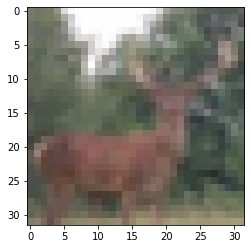

In [9]:
import sys
sys.path.append("/home/hrushikesh/robust/vgg19")
from vgg_change import VGG as UGG
n_model = UGG()
n_model.eval()
n_model.load_state_dict(torch.load("/home/hrushikesh/robust/vgg19/batchout_many/n_3/model_reg_121.pt"))
n_fmodel = fb.PyTorchModel(n_model, bounds=(0,1), preprocessing=preprocessing)
image = X[i][None, :, :, :]
plt.imshow(X[i].cpu().numpy().transpose(1, 2, 0))
model_pred = n_fmodel(image)
print(model_pred)

print(nn.Softmax(dim=1)(model_pred))

print(classes[int(model_pred.argmax())])


4
tensor([[False]], device='cuda:0')
1
tensor([[-0.6133, -1.0886,  0.1053,  0.6928,  1.8068,  0.3104,  0.1947, -0.2193,
         -0.6009, -0.9522]], device='cuda:0')
tensor([[0.0376, 0.0234, 0.0772, 0.1389, 0.4231, 0.0947, 0.0844, 0.0558, 0.0381,
         0.0268]], device='cuda:0')
deer


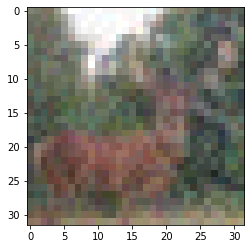

In [21]:
attack = fb.attacks.FGSM()

print(int(y[i]))
label = torch.Tensor([int(y[i])]).long().to(device) 

raw, clipped, is_adv = attack(fmodel, X[i][None, :, :, :], label, epsilons=[8/255])
clipped_img = clipped[0][0][None, :, :, :]
print(is_adv)
print(len(clipped))
plt.imshow(clipped_img[0].cpu().numpy().transpose(1, 2, 0))

model_pred = fmodel(clipped_img)
print(model_pred)
print(nn.Softmax(dim=1)(model_pred))
print(classes[int(model_pred.argmax())])

4
tensor([[False]], device='cuda:0')
1
tensor([[-0.4215, -0.4831,  0.1953,  0.4000,  1.3788, -0.0412,  0.5523, -0.1762,
         -0.3589, -0.8679]], device='cuda:0')
tensor([[0.0521, 0.0489, 0.0964, 0.1184, 0.3150, 0.0761, 0.1378, 0.0665, 0.0554,
         0.0333]], device='cuda:0')
deer


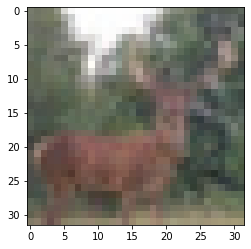

In [24]:
attack = fb.attacks.FGM()

print(int(y[i]))
label = torch.Tensor([int(y[i])]).long().to(device) 

raw, clipped, is_adv = attack(fmodel, X[i][None, :, :, :], label, epsilons=[0.5])
clipped_img = clipped[0][0][None, :, :, :]
print(is_adv)
print(len(clipped))
plt.imshow(clipped_img[0].cpu().numpy().transpose(1, 2, 0))

model_pred = fmodel(clipped_img)
print(model_pred)
print(nn.Softmax(dim=1)(model_pred))
print(classes[int(model_pred.argmax())])